## Setting the environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Setting toolkit folder as working directory

%cd /content/drive/My Drive/Datasets/Platinum Challange
! ls


/content/drive/My Drive/Datasets/Platinum Challange
'[2] slangword-stopword-removal.ipynb'	   tfidf_vectorizer_rdf.pkl
 a2_glove.6B.100d.txt			   tokenizer_lstm_balanced_data.pickle
 id.stopwords.02.01.2016.txt		   tokenizer_lstm_new.pickle
 _json_colloquial-indonesian-lexicon.txt   tokenizer_lstm_new_.pickle
 model_lstm_balanced_data.h5		   tokenizer_lstm.pickle
 model_lstm_goodfit.h5			   tokenizer_lstm_stopword.pickle
 model_lstm_new.h5			   train_preprocess.tsv
 model_lstm_new_.h5			   tweets10.csv
 model_lstm_overfitting.h5		   x_pad_sequences_lstm_balanced_data.pickle
 model_lstm_stopword.h5			   x_pad_sequences_lstm_new.pickle
 model_mlp_balanced_data.pkl		   x_pad_sequences_lstm_new_.pickle
 model_mlp_new.pkl			   x_pad_sequences_lstm.pickle
 model_mlp.pkl				   x_pad_sequences_lstm_stopword.pickle
 model_rdf.pkl				   y_labels_lstm_balanced_data.pickle
 predicted_sentiments.json		   y_labels_lstm_new.pickle
 tfidf_vectorizer_mlp_balanced_data.pkl    y_labels_lstm_new_.pickle
 

In [17]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
import tensorflow as tf
from sklearn.model_selection import train_test_split


## Loading dataset

In [4]:
#dataset
data = pd.read_csv("train_preprocess.tsv", sep='\t', names=['text', 'sentiment'])
data

,text,sentiment
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [5]:
# Checking for missing values
data.isnull().values.any()

False

In [6]:
#data duplicate
data.duplicated().values.any()

True

In [7]:
data[data.duplicated()]

,text,sentiment
948,berantakan,negative
1205,jangan pernah kecewa dengan apa yang diberikan...,positive
1367,bersyukur,positive
2616,apresiasi,positive
2708,tidak berantakan,positive
...,...,...
10927,tidak indah,negative
10950,bank bca di pgc payah sekali pelayanan nya . j...,negative
10979,berkesempatan menikmati santap pagi dikarenaka...,positive
10995,tidak kecewa,positive


In [8]:
# Removing duplicates
data.drop_duplicates(inplace=True)
# Checking for duplicates again
data.duplicated().sum()

0

In [9]:
#mereset index data
data=data.reset_index(drop=True)

In [10]:
data['total_word'] = data['text'].apply(lambda txt: len(txt.split()))
data

,text,sentiment,total_word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38
...,...,...,...
10928,f - demokrat dorong upaya kemandirian energi n...,neutral,8
10929,tidak bosan,positive,2
10930,enak rasa masakan nya apalagi kepiting yang me...,positive,26
10931,"pagi pagi di tol pasteur sudah macet parah , b...",negative,13


### EDA

In [11]:
data.groupby('sentiment').sentiment.count()

,sentiment
sentiment,
negative,3412
neutral,1138
positive,6383


<Axes: xlabel='sentiment', ylabel='count'>

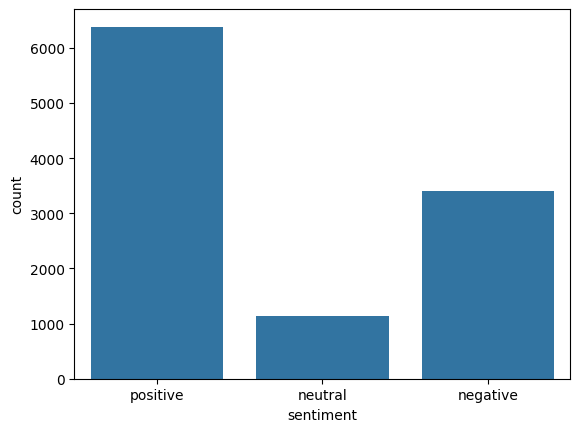

In [12]:
import seaborn as sns
sns.countplot(x='sentiment', data=data)

<Axes: ylabel='sentiment'>

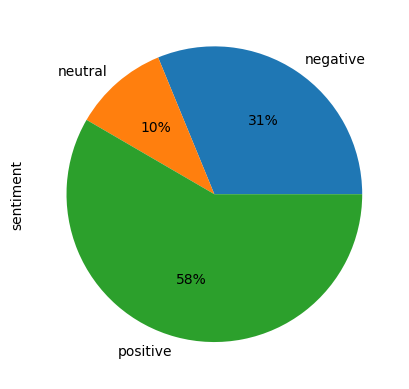

In [13]:
data.groupby('sentiment').sentiment.count().plot(kind='pie', autopct='%1.0f%%')

In [14]:
grouped_word = data.groupby('sentiment')['total_word'].sum()
grouped_word

,total_word
sentiment,
negative,81372
neutral,16756
positive,263323


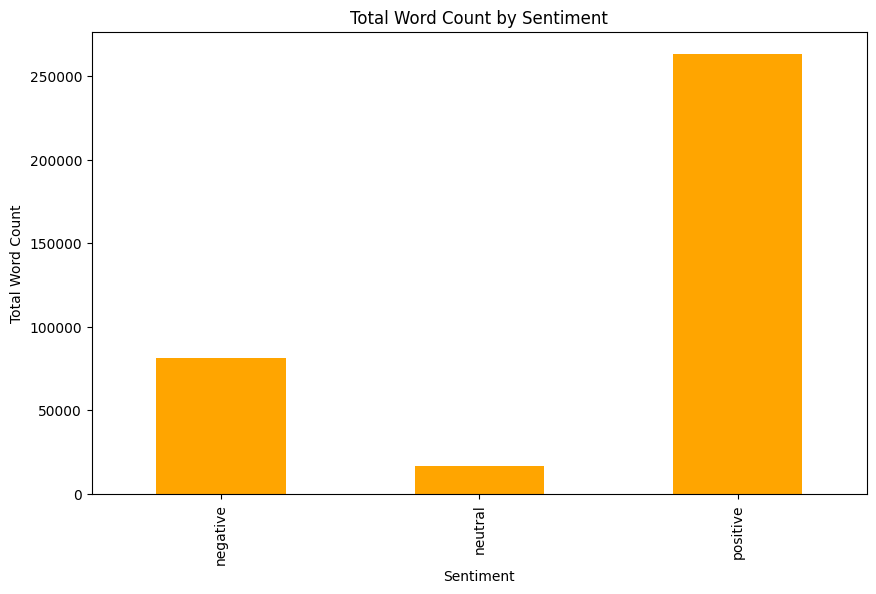

In [19]:
# Membuat bar chart
plt.figure(figsize=(10, 6))
grouped_word.plot(kind='bar', color='orange')

# Menambahkan judul dan label
plt.title('Total Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Total Word Count')

# Menampilkan plot
plt.show()


In [20]:
avg_count_word = data.groupby('sentiment')[['total_word']].mean()
avg_count_word

,total_word
sentiment,
negative,23.848769
neutral,14.724077
positive,41.253799


<Figure size 1000x600 with 0 Axes>

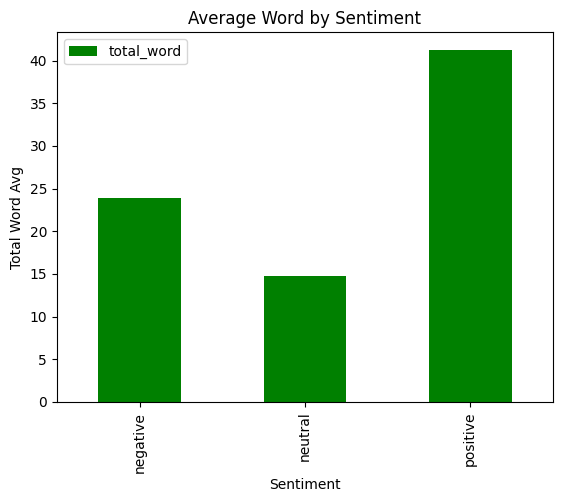

In [21]:
# Membuat bar chart
plt.figure(figsize=(10, 6))
avg_count_word.plot(kind='bar', color='green')

# Menambahkan judul dan label
plt.title('Average Word by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Total Word Avg')

# Menampilkan plot
plt.show()


In [22]:
data['total_word'].sum()

361451

In [23]:
from collections import Counter
word_counts = Counter(word for text in data['text'] for word in text.split())

# Konversi ke tuple (kata, frekuensi)
word_counts_tuple = tuple(word_counts.items())

# Hitung jumlah kata unik
unique_word_eda = len(word_counts)

print(f"Jumlah kata unik: {unique_word_eda}")

Jumlah kata unik: 18091


## Data Preprocessing

### Kamus alay

In [24]:
import json

# Menggunakan kamus kata gaul Salsabila
with open("_json_colloquial-indonesian-lexicon.txt") as f:
    kamus_alay = f.read()
# Rekonstruksi kamus_alay sebagai 'dict'
lookp_dict = json.loads(kamus_alay)

In [25]:
dict_keys = list(lookp_dict.keys())
dict_values = list(lookp_dict.values())

In [26]:
def kamus_alay(text):
  text = text.split()
  for i in text:
    if i in dict_keys:
      index = dict_keys.index(i)
      text[text.index(i)] = dict_values[index]
  return " ".join(text)

In [27]:
# Calling kamus_alay
clean_alay = []
sentences = list(data['text'])
for sen in sentences:
    clean_alay.append(kamus_alay(sen))
data['text'] = clean_alay
data.head()

,text,sentiment,total_word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,17
2,lokasi strategis di jalan sumatera bandung . t...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,38


### Cleansing

In [28]:
import re
from numpy import array

In [29]:
def text_cleaning(text):
    # Lowercase the text
    text = text.lower()

    # Define the regex pattern for removing HTML tags
    TAG_RE = re.compile(r'<[^>]+>')

    # Remove HTML tags
    text = TAG_RE.sub('', text)

    # Remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002580-\U00002BEF"  # Chinese characters
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove usernames (@), hashtags (#), and URLs (https://)
    text = re.sub(r"(@\w+|#\w+|https?://\S+)", "", text)

    # Remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove repeated characters (e.g., yesss -> yes)
    text = re.sub(r"([A-Za-z])\1{2,}", r"\1", text)

    # Remove single characters
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Remove excess spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [30]:
clean_text = []
sentences = list(data['text'])
for sen in sentences:
    clean_text.append(text_cleaning(sen))
data['text'] = clean_text
data.head()

,text,sentiment,total_word
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,66
1,mohon ulama lurus dan mmbri hujjah partai apa ...,neutral,17
2,lokasi strategis di jalan sumatera bandung tem...,positive,33
3,betapa bahagia nya diri ini saat unboxing pake...,positive,17
4,duh jadi mahasiswa jangan sombong dong kasih k...,negative,38


In [31]:
  neg = data.loc[data['sentiment'] == 'negative'].text.tolist()
  neu = data.loc[data['sentiment'] == 'neutral'].text.tolist()
  pos = data.loc[data['sentiment'] == 'positive'].text.tolist()

  neg_label = data.loc[data['sentiment'] == 'negative'].sentiment.tolist()
  neu_label = data.loc[data['sentiment'] == 'neutral'].sentiment.tolist()
  pos_label = data.loc[data['sentiment'] == 'positive'].sentiment.tolist()

In [32]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


In [33]:
from collections import Counter
word_counts = Counter(word for text in data['text'] for word in text.split())

# Konversi ke tuple (kata, frekuensi)
word_counts_tuple = tuple(word_counts.items())

# Hitung jumlah kata unik
unique_word_prep = len(word_counts)

print(f"Jumlah kata unik: {unique_word_prep}")

Jumlah kata unik: 16525


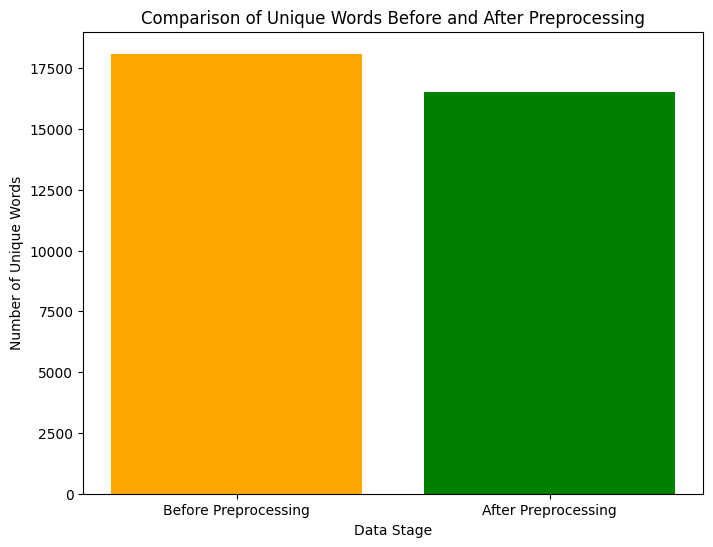

In [63]:
# Data for the bar chart
unique_words = ['Before Preprocessing', 'After Preprocessing']
counts = [unique_word_eda, unique_word_prep]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_words, counts, color=['orange', 'green'])

# Add labels and title
plt.xlabel('Data Stage')
plt.ylabel('Number of Unique Words')
plt.title('Comparison of Unique Words Before and After Preprocessing')

# Display the chart
plt.show()


### Balancing data

In [34]:
from sklearn.utils import resample

# Tetapkan target ukuran untuk setiap kategori

target_size = 1000

# Downsample

neg_downsampled = resample(neg, replace=False, n_samples=target_size, random_state=3)
neg_label_downsampled = ['negative' for _ in range(target_size)]

neu_downsample = resample(neu, replace=False, n_samples=target_size, random_state=3)
neu_label_downsampled = ['neutral' for _ in range(target_size)]

pos_downsampled = resample(pos, replace=False, n_samples=target_size, random_state=3)
pos_label_downsampled = ['positive' for _ in range(target_size)]

# Gabungkan data yang telah di-resample

balanced_data = neg_downsampled + neu_downsample + pos_downsampled
balanced_labels = neg_label_downsampled + neu_label_downsampled + pos_label_downsampled

In [35]:
print("Pos: %s, Neu: %s, Neg: %s" % (len(pos_downsampled), len(neu_downsample), len(neg_downsampled)))
print("Total data: %s" % len(balanced_data))

Pos: 1000, Neu: 1000, Neg: 1000
Total data: 3000


In [36]:
from collections import Counter

word_counts = Counter(word for text in data['text'] for word in text.split())
len(word_counts)

16525

## Building

### LSTM

#### Feature Extraction
Setelah itu kita lakukan Feature Extraction menggunakan modul "Tokenizer" dan "pad_sequences" dari Tensorflow.

Module Tokenizer memungkinkan untuk memvektorisasi korpus teks, dengan mengubah setiap teks menjadi urutan bilangan bulat (setiap bilangan bulat menjadi indeks token dalam kamus) atau menjadi vektor di mana koefisien untuk setiap token bisa biner, berdasarkan jumlah kata , berdasarkan tf-idf.

Module pad_sequences memungkinkan mengubah list dari sequences menjadi array bentuk 2D.

In [37]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = unique_word_prep
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)

with open('tokenizer_lstm_new_.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer_lstm_new_.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences_lstm_new_.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences_lstm_new_.pickle has created!")

tokenizer_lstm_new_.pickle has created!
x_pad_sequences_lstm_new_.pickle has created!


In [38]:
maxlen

85

In [39]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels_lstm_new_.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels_lstm_new_.pickle has created!")

y_labels_lstm_new_.pickle has created!


#### Train Test Split

In [40]:
import pickle

In [41]:
file = open("x_pad_sequences_lstm_new_.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels_lstm_new_.pickle",'rb')
Y = pickle.load(file)
file.close()

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

In [43]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import tensorflow as tf

In [44]:
tf.keras.backend.clear_session()

In [45]:
units = 128
embed_dim = 100
maxlen = 85

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 66s 230ms/step - accuracy: 0.7419 - loss: 0.6434 - val_accuracy: 0.9269 - val_loss: 0.2393
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 54s 195ms/step - accuracy: 0.9271 - loss: 0.2119 - val_accuracy: 0.9651 - val_loss: 0.1146
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 72s 160ms/step - accuracy: 0.9627 - loss: 0.1083 - val_accuracy: 0.9806 - val_loss: 0.0641
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.9724 - loss: 0.0706 - val_accuracy: 0.9834 - val_loss: 0.0431
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - accuracy: 0.9808 - loss: 0.0503 - val_accuracy: 0.9771 - val_loss: 0.0641
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 43s 156ms/step - accuracy: 0.9802 - loss: 0.0428 - val_accuracy: 0.9891 - val_loss: 0.0345
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 89s 183ms/step - accuracy: 0.9886 - loss: 0.0287 - val_accuracy: 0.9926 - val_loss: 0.0201
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 153ms/step - accuracy: 0.9940 - loss: 0.0177 - val

In [46]:
model.save('model_lstm_new_.h5')
print("Model has created!")

Model has created!


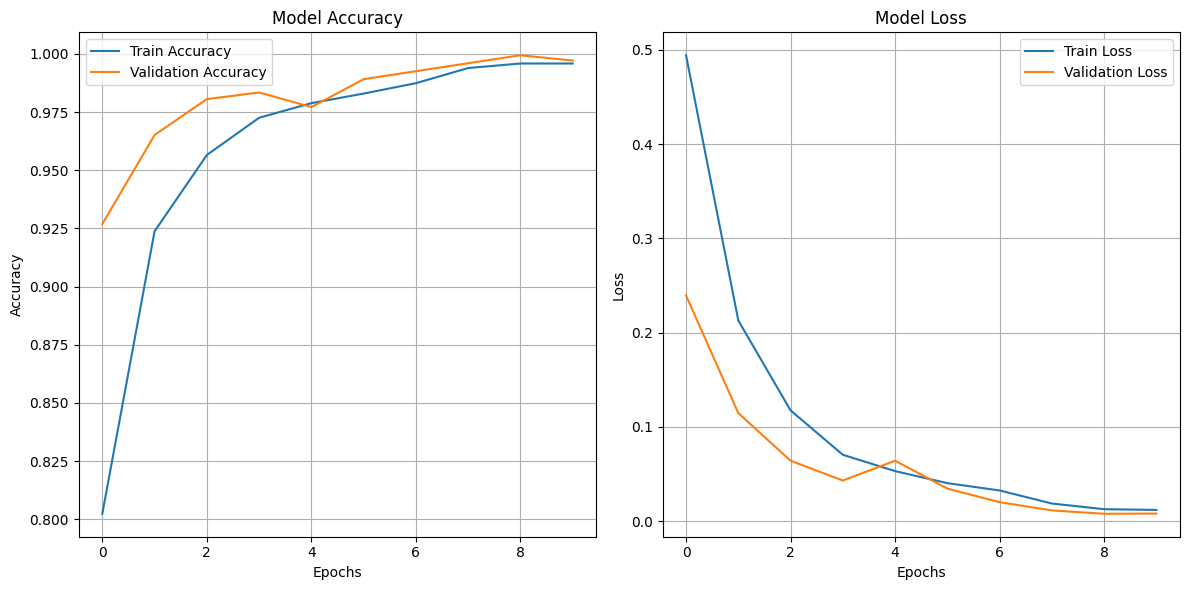

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()

# Training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [48]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       650
           1       0.82      0.69      0.75       223
           2       0.89      0.91      0.90      1314

    accuracy                           0.85      2187
   macro avg       0.83      0.80      0.81      2187
weighted avg       0.85      0.85      0.85      2187



#### Input text

In [49]:
import re
import json
import pickle
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

input_text = input("Masukan text: ")

def cleansing(text):
    text = kamus_alay(text)
    text = text_cleaning(text)
    return text

sentiment = ['negative', 'neutral', 'positive']

# Load model LSTM
model = load_model('model_lstm_new.h5')

# Load tokenizer
with open("tokenizer_lstm_new.pickle", 'rb') as file:
    tok = pickle.load(file)

# Define maxlen (adjust according to your model's requirements)
maxlen = 85

# Cleanse input text
text = [cleansing(input_text)]
predicted = tok.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=maxlen)

# Predict sentiment
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

# Create result dictionary
result = {
    "input_text": input_text,
    "cleaned_text": text[0],
    "sentiment": sentiment[polarity],
    "probability": np.max(prediction).item()  # Convert numpy type to native Python type
}

# Convert result dictionary to JSON
result_json = json.dumps(result, indent=4)

# Print result JSON
print(result_json)


Masukan text: wahh bagus banget


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
{
    "input_text": "wahh bagus banget",
    "cleaned_text": "wah bagus banget",
    "sentiment": "positive",
    "probability": 0.9998254179954529
}


#### Input file

In [50]:
# Baca file CSV
file_path = 'tweets10.csv'  # Ganti dengan path file CSV Anda
df = pd.read_csv(file_path)
df

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655
5,katyperry,happy 96th gma #fourmoreyears! 🎈 @ LACMA Los A...,NaN,09/01/2017 01:00,8.182610e+17,en,NaN,NaN,8242,2164
6,katyperry,🇯🇵 @ Sanrio Puroland https://t.co/eXVev5UMBx,NaN,02/01/2017 09:31,8.158530e+17,cy,NaN,NaN,7766,2468
7,katyperry,2017 resolution: to embody authenticity!,NaN,01/01/2017 03:31,8.154000e+17,en,NaN,NaN,23662,8430
8,katyperry,🇯🇵 @ Sanrio Puroland https://t.co/eXVev5UMBx,NaN,02/01/2017 09:31,8.158530e+17,cy,NaN,NaN,7766,2468
9,katyperry,2017 resolution: to embody authenticity!,NaN,01/01/2017 03:31,8.154000e+17,en,NaN,NaN,23662,8430


In [51]:
import json
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model


# Daftar label sentimen
sentiment = ['negative', 'neutral', 'positive']

# Fungsi pembersihan teks
def cleansing(text):
    text = kamus_alay(text)
    text = text_cleaning(text)
    return text

# Load tokenizer
with open("tokenizer_lstm_new.pickle", 'rb') as file:
    tok = pickle.load(file)

# Load model
model = load_model('model_lstm_new.h5')

# Maxlen
maxlen = 85

# List untuk menyimpan hasil
results = []

# Proses setiap baris dalam file CSV
for index, row in df.iterrows():
    input_text = row['content']
    cleaned_text = cleansing(input_text)

    predicted = tok.texts_to_sequences([cleaned_text])
    guess = pad_sequences(predicted, maxlen=maxlen)
    prediction = model.predict(guess)
    polarity = np.argmax(prediction[0])

    # Buat dictionary untuk setiap hasil
    result = {
        "input_text": input_text,
        "cleaned_text": cleaned_text,
        "sentiment": sentiment[polarity],
        "probability": np.max(prediction).item()  # Convert numpy type to native Python type
    }

    # Tambahkan hasil ke list
    results.append(result)

# Convert list of dictionaries to JSON
output_json = json.dumps(results, indent=4)

print(output_json)

# Simpan hasil ke file JSON
with open('predicted_sentiments.json', 'w') as json_file:
    json_file.write(output_json)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[
    {
        "input_text": "Is history repeating itself...?#DONTNORMALIZEHATE https://t.co/ngG11quhmK",
        "cleaned_text": "is history repeating itself",
        "sentiment": "positive",
        "probability": 0.5766736268997192
    },
    {
        "input_text": "@barackobama Thank you for your incredible grace in leadership and for being an exceptional\u2026 https://t.co/ZuQLZpt6df",
        "cleaned_text": "thank you for your incredible grace ini leadership and for being an exceptional",
        "sentiment": "positive",
        "probability": 0.9778752326965332
    },
    {
        "input_text": "Life

### MLPclassifier

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import numpy as np

In [53]:
# Tokenisasi dan vektorisasi
vectorizer = TfidfVectorizer(max_features=unique_word_prep)
X = vectorizer.fit_transform(total_data).toarray()

# Encoding label
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Pembagian data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Membuat dan melatih model dengan dua hidden layer
model = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=100, activation='relu', solver='adam', random_state=42)
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=100, random_state=42)

In [55]:
# Save the vectorizer and model
with open('tfidf_vectorizer_mlp_new.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

with open('model_mlp_new.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [56]:
# Prediksi pada data uji
y_pred = model.predict(X_test)

# Mengukur performa model
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.79      0.78      0.78       681
     neutral       0.78      0.63      0.69       235
    positive       0.87      0.91      0.89      1271

    accuracy                           0.84      2187
   macro avg       0.81      0.77      0.79      2187
weighted avg       0.84      0.84      0.84      2187



#### Input text

In [57]:
import numpy as np
import json

In [61]:
# Daftar label sentimen
sentiment = ['negative', 'neutral', 'positive']

# Input teks
input_text = input("Masukan text: ")

def cleansing(text):
  text = kamus_alay(text)
  text = text_cleaning(text)
  return text

cleaned_text = cleansing(input_text)

# Load the pre-trained vectorizer and model
with open('tfidf_vectorizer_mlp_new.pkl', 'rb') as vec_file:
    vectorizer = pickle.load(vec_file)  # Load the vectorizer object

with open('model_mlp_new.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Transform input text using the pre-trained vectorizer
text_vector = vectorizer.transform([cleaned_text])

# Predict sentiment
prediction = model.predict(text_vector)
probability = model.predict_proba(text_vector)

# Determine sentiment
polarity = sentiment[prediction[0]]

# print("Text: ", cleaned_text)
# print("Sentiment: ", polarity)
# print("Probability: ", np.max(probability))

output = {
    "input_text": input_text,
    "cleaned_text": cleaned_text,
    "sentiment": polarity,
    "probability": np.max(probability).item()
}

# Convert dictionary to JSON
output_json = json.dumps(output, indent=4)

print(output_json)

Masukan text: wahh bagus banget
{
    "input_text": "wahh bagus banget",
    "cleaned_text": "wah bagus banget",
    "sentiment": "positive",
    "probability": 0.9977543788004846
}


#### Input file

In [59]:
# Baca file CSV
file_path = 'tweets10.csv'  # Ganti dengan path file CSV Anda
df = pd.read_csv(file_path)
df

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655
5,katyperry,happy 96th gma #fourmoreyears! 🎈 @ LACMA Los A...,NaN,09/01/2017 01:00,8.182610e+17,en,NaN,NaN,8242,2164
6,katyperry,🇯🇵 @ Sanrio Puroland https://t.co/eXVev5UMBx,NaN,02/01/2017 09:31,8.158530e+17,cy,NaN,NaN,7766,2468
7,katyperry,2017 resolution: to embody authenticity!,NaN,01/01/2017 03:31,8.154000e+17,en,NaN,NaN,23662,8430
8,katyperry,🇯🇵 @ Sanrio Puroland https://t.co/eXVev5UMBx,NaN,02/01/2017 09:31,8.158530e+17,cy,NaN,NaN,7766,2468
9,katyperry,2017 resolution: to embody authenticity!,NaN,01/01/2017 03:31,8.154000e+17,en,NaN,NaN,23662,8430


In [60]:
import json
import numpy as np
import pickle
import pandas as pd

# Daftar label sentimen
sentiment = ['negative', 'neutral', 'positive']

# Fungsi pembersihan teks
def cleansing(text):
    text = kamus_alay(text)
    text = text_cleaning(text)
    return text

# Load the pre-trained vectorizer and model
with open('tfidf_vectorizer_mlp.pkl', 'rb') as vec_file:
    vectorizer = pickle.load(vec_file)  # Load the vectorizer object

with open('model_mlp.pkl', 'rb') as model_file:
    model = pickle.load(model_file)


# List untuk menyimpan hasil
results = []

# Proses setiap baris dalam file CSV
for index, row in df.iterrows():
    input_text = row['content']  # Ganti 'text' dengan nama kolom yang sesuai di file CSV Anda
    cleaned_text = cleansing(input_text)
    text_vector = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)
    polarity = sentiment[prediction[0]]

    # Buat dictionary untuk setiap hasil
    result = {
        "input_text": input_text,
        "cleaned_text": cleaned_text,
        "sentiment": polarity,
        "probability": np.max(probability).item()  # Convert numpy type to native Python type
    }

    # Tambahkan hasil ke list
    results.append(result)

# Convert list of dictionaries to JSON
output_json = json.dumps(results, indent=4)

print(output_json)


[
    {
        "input_text": "Is history repeating itself...?#DONTNORMALIZEHATE https://t.co/ngG11quhmK",
        "cleaned_text": "is history repeating itself",
        "sentiment": "negative",
        "probability": 0.5264880639529463
    },
    {
        "input_text": "@barackobama Thank you for your incredible grace in leadership and for being an exceptional\u2026 https://t.co/ZuQLZpt6df",
        "cleaned_text": "thank you for your incredible grace ini leadership and for being an exceptional",
        "sentiment": "positive",
        "probability": 0.9999979438717591
    },
    {
        "input_text": "Life goals. https://t.co/XIn1qKMKQl",
        "cleaned_text": "life goals",
        "sentiment": "neutral",
        "probability": 0.8166553184145726
    },
    {
        "input_text": "Me right now \ud83d\ude4f\ud83c\udffb https://t.co/gW55C1wrwd",
        "cleaned_text": "me right now",
        "sentiment": "positive",
        "probability": 0.9993956601604549
    },
    {
       